In [ ]:
!pip install google-cloud-automl
!pip install google-cloud-storage
!pip install opencv-python==3.3.0.9
!pip install keras
!pip install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl

In [4]:
from google.cloud import storage
from IPython.display import Image
from PIL import Image as Img
from imageai.Detection import ObjectDetection
import math
import cv2
import numpy as np
import io
import glob

ImportError: No module named 'imageai'

In [8]:
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = 'saleshousephotos'

bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs()

photos = []
for blob in blobs:
  if 'photos' in blob.name:
    photos.append(blob.name)
photos = photos[1:]
  
tmp = bucket.blob(photos[-1]).download_as_string()
img = Img.open(io.BytesIO(tmp))
img = np.array(img)
print(True)

NameError: name 'io' is not defined

In [9]:
photos

['photos/2229526-visit-1339543-GLOBUS_Prazska_248-39_Olomouc_77900_(S2322CZ)-2018-09-17-03-36.jpg',
 'photos/2229883-visit-1339601-Albert-Interspar_Vychodni_1352_Stare_Mesto_68603_(S2408CZ)-2018-09-17-07-23.jpg',
 'photos/2229921-visit-1339643-Tesco_Brnenska_1825-23a_Hradec_Kralove_50009_(S2689CZ)-2018-09-17-07-27.jpg',
 'photos/2229945-visit-1339568-Tesco_Novinarska_3178-6a_Ostrava_Moravska_Ostrava_a_Privoz_70200_(S2704CZ)-2018-09-17-07-30.jpg',
 'photos/2229993-visit-1339643-Tesco_Brnenska_1825-23a_Hradec_Kralove_50009_(S2689CZ)-2018-09-17-07-39.jpg',
 'photos/2230241-visit-1339705-Tesco_Sjizdna_5554-2_Ostrava_Trebovice_72200_(S2698CZ)-2018-09-17-08-36.jpg',
 'photos/2230418-visit-1339778-Tesco_Kojetinska_3133-10_Prerov_75002_(S2677CZ)-2018-09-17-09-09.jpg',
 'photos/2230815-visit-1339893-Hyperalbert_Radlicka_520-117_Praha_Praha_5_15800_(S2798CZ)-2018-09-17-10-22.jpg',
 'photos/2230946-visit-1339936-Tesco_Narodni_63-26_Praha_Praha_1_11000_(S2751CZ)-2018-09-17-10-35.jpg',
 'photos/223

In [ ]:
def blur_image(image, amount=5):
    '''Blurs the image
    Does not affect the original image'''
    kernel = np.ones((amount, amount), np.float32) / (amount**2)
    return cv2.filter2D(image, -1, kernel)
    
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 250, 250)
image = blur_image(edges, amount = 7)

lines = cv2.HoughLinesP(image, rho = 1, theta = math.pi, threshold = 20, minLineLength = img.shape[0]/1.5, maxLineGap = 0)

if lines is None:
    lines = cv2.HoughLinesP(image, rho = 1, theta = math.pi, threshold = 50, minLineLength = img.shape[0]/2.5, maxLineGap = 3)

img2 = img.copy()
lines = sorted(lines,key=lambda x: x[0,0])
dominance = -1000
right_chop = img.shape[1]
left_chop = 0

for line2 in range(len(lines)):
    line = lines[line2]
    if line[0,0] - dominance > 0.2*img.shape[1]:
        if (line[0,0] < 0.2*img.shape[1] or line[0,0] > 0.8*img.shape[1]):
            if (line[0,0] < 0.2*img.shape[1]):
              left_chop = line[0,0]
            if (line[0,0] > 0.8*img.shape[1]):
              right_chop = line[0,0]
            pt1 = (line[0,0],line[0,1])
            pt2 = (line[0,2],line[0,3])
            cv2.line(img, pt1, pt2, (0,0,255), 3)
            dominance = line[0,0]
    pt1 = (line[0,0],line[0,1])
    pt2 = (line[0,2],line[0,3])
    cv2.line(img2, pt1, pt2, (0,0,255), 3)

Img.fromarray(img)

In [ ]:
Img.fromarray(img2)

In [5]:
img_chopped = img[:,left_chop:right_chop,:]

In [6]:
PERC = 30

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("./temp_model.h5")
detector.loadModel()

custom_objects = detector.CustomObjects(person=False, car=False, bottle = True)
main_obj, detections, extracted_obj = detector.detectCustomObjectsFromImage(input_image= img_chopped, 
                                                    input_type="array",
                                                    output_type = 'array', 
                                                    output_image_path= "./im.png", 
                                                    custom_objects=custom_objects,
                                                    extract_detected_objects=True,
                                                    minimum_percentage_probability=PERC)
        
detections_all = detections.copy()

In [ ]:
img_chopped_black = img_chopped.copy()
for i in range(len(detections)):
    img_chopped_black[detections[i]['box_points'][1]:detections[i]['box_points'][3],detections[i]['box_points'][0]:detections[i]['box_points'][2],:] = 0
Img.fromarray(img_chopped_black, 'RGB')

In [ ]:
PERC = 5

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("./temp_model.h5")
detector.loadModel()

custom_objects = detector.CustomObjects(person=False, car=False, bottle = True)
main_obj, detections, extracted_obj = detector.detectCustomObjectsFromImage(input_image= img_chopped_black, 
                                                    input_type="array",
                                                    output_type = 'array', 
                                                    output_image_path= "./im.png", 
                                                    custom_objects=custom_objects,
                                                    extract_detected_objects=True,
                                                    minimum_percentage_probability=PERC)
for i in detections:        
  detections_all.append(i)
Img.fromarray(main_obj, 'RGB')

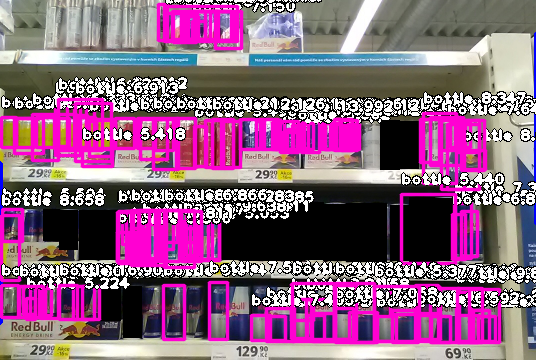

In [41]:
Img.fromarray(main_obj, 'RGB')

TypeError: list indices must be integers or slices, not str

In [19]:
shelf_tuple = [(l['box_points'][0], l['box_points'][2]) for l in detections_all]
shelf_tuple.append((0,0))
shelf_tuple.append((img_chopped.shape[1], img_chopped.shape[1]))
sorted_by_lower_bound = sorted(shelf_tuple, key=lambda tup: tup[0])
merged = []

for higher in sorted_by_lower_bound:
      if not merged:
          merged.append(higher)
      else:
          lower = merged[-1]
          if higher[0] <= lower[1]:
              upper_bound = max(lower[1], higher[1])
              merged[-1] = (lower[0], upper_bound)  # replace by merged interval
          else:
              merged.append(higher)
#zastoupeni = sum([i[1] - i[0] for i in merged])/sz 

In [20]:
merged

[(0, 0), (1, 499), (536, 536)]

In [21]:
remove = []
for i in range(len(merged)-1):
  if merged[i+1][0]-merged[i][1] > img_chopped.shape[1]*0.05:
    remove.append((merged[i][1], merged[i+1][0]))
    

In [22]:
remove

[(499, 536)]

In [37]:
img_chopped_fin = img_chopped.copy()
down_grade = 0
for i in remove:
  #img_chopped_fin = img_chopped_fin[:,0:i[0] - down_grade + 1,:] + img_chopped_fin[:,i[1]- down_grade - 1:,:]
  img_chopped_fin = img_chopped_fin[:, np.r_[0:i[0] - down_grade + 1,i[1]- down_grade - 1: img_chopped_fin.shape[1]], :]
  down_grade += i[1] - i[0]

In [ ]:
Img.fromarray(img_chopped_fin)

In [ ]:
Img.fromarray(img_chopped)

In [43]:
def compute_seed_shelves(detections, polish=1/4):
    """"""
    GAP = 15
    frame_indeces = {i for i in range(len(detections))}    
    shelf = -1
    shelves = []
    while frame_indeces:
        shelf_frames = set()  
        for i in frame_indeces:
            frame = detections[i]
#            current_frame = colour_frame(main_obj, frame)
#            Image.fromarray(current_frame, 'RGB').show()
            dominated_by = (detections[i] for i in frame.get('dominated_by', {}))
            if all(dominating_frame.get('shelf', float('inf')) <= shelf 
                   for dominating_frame in dominated_by):
                x1, y1, x2, y2 = frame['box_points']
                upper_shelf_bottoms = [detections[i]['box_points'][3] for i in shelves[-1]] if shelf > -1 else []
                if sum(y2_ >= y2 - GAP for y2_ in upper_shelf_bottoms) > polish*len(upper_shelf_bottoms):
#                if all(y2_ >= y2 - GAP for y2_ in upper_shelf_bottoms):

                    frame['shelf'] = shelf
                    shelves[-1].add(i)
                else:
                    frame['shelf'] = shelf + 1
                    next_shelf = True
                    shelf_frames.add(i)
#                main_obj = colour_frame(main_obj, frame, colour=colour_map(shelf))
#                img = Image.fromarray(main_obj, 'RGB')
        frame_indeces -= shelf_frames
        if shelf > -1:
            frame_indeces -= shelves[-1]
        shelves.append(shelf_frames)

        shelf += 1 if next_shelf else 0
    return detections


def detect_nonshelves(detections, main_obj):
    """"""
    shelves = [set()  for _ in range(20)]
    for iframe, frame in enumerate(detections):
        shelves[frame['shelf']].add(iframe)
        
    image_width = main_obj.shape[1]
    to_remove = []
    for ishelf, shelf in enumerate(shelves[:-1]):
        lower_tops = [(detections[j]['box_points'][1], detections[j]['box_points'][2]) for j in shelves[ishelf+1]]
        if not lower_tops:
            continue
        noshelf = []
        for i in shelf:
            frame = detections[i]
            frame_bottom = frame['box_points'][3]
            if any(y1 < frame_bottom for y1, y2 in lower_tops):
#                frame['shelf'] = -1
                noshelf.append(frame)
#        Image.fromarray(colour_shelves(noshelf, main_obj.copy()), 'RGB').show()
        safety_condition = noshelf and (min(f['box_points'][0] for f in noshelf) > image_width*1/2
                        or max(f['box_points'][2] for f in noshelf) < image_width*1/2)
        if safety_condition:
            for f in noshelf:
                f['shelf'] = -1
            to_remove.extend(noshelf)
    for frame in detections:
        if to_remove:
            if frame['box_points'][2] > image_width/2:
                if frame['box_points'][2] >= min(f['box_points'][0] for f in to_remove) > image_width/2:
                    frame['shelf'] = -1
            elif frame['box_points'][2] < image_width/2:
                if frame['box_points'][0] <= max(f['box_points'][2] for f in to_remove) < image_width/2:
                    frame['shelf'] = -1

      
def colour_shelves(detections, main_obj):
    """"""
    for frame in detections:
        if 'shelf' in frame:
            main_obj = colour_frame(main_obj, frame, colour=colour_map(frame['shelf']))
    return main_obj


def detect(detections, polish=1/4):
    """Detekuje regaly na zaklade detekci lahvi. Vadi FALSE POSITIVES.
    V prvni iteraci je ale treba ponechat vysi FALSE POSITVES, abychom meli nizsi FALSE NEGATIVES,
    nebot FALSE NEGATIVES zase budou vadit nasledujicimu `correct` kroku.
    V pripade ze se v dalsich iteracich snizi FALSE POSITIVES, bude mozna treba zvysovat parametr `polish` smerem k 0.99.
    Parametr polish sleva "falesne regaly" do jednoho.
    """
    compute_dominance_relations(detections)   
    detections = compute_seed_shelves(detections, polish)
    return detections


def correct(detections, main_obj):
    """Odstrani lahve stojici v sousednich regalech. Vadi FALSE NEGATIVES.
    Input
    ----
    detections : list of dicts
        detections with `shelf` attribute from `detect` method
    main_obj : array 
        image from the bottle detector
    """
    detect_nonshelves(detections, main_obj)
    
    main_obj = colour_shelves(detections, main_obj.copy())

    detections_ = []
    for d in detections:
        if d.pop('shelf') > -1:
            if 'dominated_by' in d:
                d.pop('dominated_by')
            detections_.append(d)
    
    return detections_
  
  
  
  
  
  
def colour_frame(img, frame, width=3, colour=[0, 0, 0]):
    """"""
    x1, y1, x2, y2 = frame['box_points']
    img[y1:y2, x1:x1+width] = colour
    img[y1:y2, x2-width:x2] = colour
    img[y1:y1+width, x1:x2] = colour
    img[y2-width:y2, x1:x2] = colour
    return img


def colour_map(shelf):
    MAP = {0: [255, 0, 0], 1: [0, 0, 255], 2: [0, 255, 0], 3: [0, 255, 255], 4: [255, 255, 0], 5: [28,128,128]}
    return MAP.get(shelf % len(MAP))


def compute_dominance_relations(detections):
    """"""
    for i, frame in enumerate(detections):
        x1, y1, x2, y2 = frame['box_points']
        for j, frame_ in enumerate(detections):
            x1_, y1_, x2_, y2_ = frame_['box_points']
            if y2 < y1_:
                dominated_by = frame_.setdefault('dominated_by', set())
                dominated_by.add(i)
       
 
def mean_bottom_polishing(shelves, detections, main_obj):
    """"""
    def mean_bottom_polishing_(shelves, detections):
        shelf = 0
        for shelf_frames in shelves[:-1]:
            lower_shelf_frames = shelves[shelf+1]
            shelf_bottoms = [detections[i]['box_points'][3] for i in shelf_frames]
            avg_bottom = np.mean(shelf_bottoms)
            to_be_merged = set()
            for i in lower_shelf_frames:
                if avg_bottom > detections[i]['box_points'][1]:
                    detections[i]['shelf'] = shelf
                    to_be_merged.add(i)  
            shelf_frames |= to_be_merged  
            lower_shelf_frames -= to_be_merged
    
            shelf += 2 if to_be_merged else 1
            if shelf >= len(shelves) - 1:
                break 
        return [shelf for shelf in shelves if shelf]
    
    while True: 
        shelves2 = shelves.copy()  
        main_obj = colour_shelves(detections, main_obj)
#        Image.fromarray(main_obj, 'RGB').show()
        shelves = mean_bottom_polishing_(shelves, detections)
        if shelves == shelves2:
            return shelves
    
    
def polish_nonshlef_frames(shelves, detections):
    for ishelf in range(len(shelves[:-1])):
        shelf = shelves[ishelf]
        lower_shelf = shelves[ishelf+1]
        to_remove = {i for i in shelf if not all(i in detections[j].get('dominated_by', {}) for j in lower_shelf)}
        if to_remove:
            shelf -= to_remove
            for i in to_remove:
                detections[i].pop('shelf')
    return shelves


def detect_shelves(detection, main_obj):
    """
    Input
    -----
    detections : list
        detected frames provided by `ObjectDetection`
    main_obj : image
        original image with colored `detection` provided by `ObjectDetection`
    
    Returns
    -------
    shelves : list of shelves (top-down) 
        with each shelf as a set of respective frame-indices pointing to `detections`
    main_obj : image
        original image with colored shelves   
    """
    compute_dominance_relations(detections)   

    shelves = compute_seed_shelves(detections)

    shelves = mean_bottom_polishing(shelves,detections, main_obj)
    
#    shelves = polish_nonshlef_frames(shelves, detections)     
       
    main_obj = colour_shelves(detections, main_obj)

    return shelves, main_obj


# kubex

def colour_shelves_prediction(shelves, detections, main_obj):
    """"""
    for i, shelf in enumerate(shelves):
        for iframe in shelf:
          if detections[iframe]['class'] == 'RB':
            main_obj = colour_frame(main_obj, detections[iframe], colour=colour_map(2))
          elif detections[iframe]['class'] == 'RBsf':
            main_obj = colour_frame(main_obj, detections[iframe], colour=colour_map(4))
          else: 
            main_obj = colour_frame(main_obj, detections[iframe], colour=colour_map(5))
    return main_obj
  
def blur_image(image, amount=5):
    '''Blurs the image
    Does not affect the original image'''
    kernel = np.ones((amount, amount), np.float32) / (amount**2)
    return cv2.filter2D(image, -1, kernel)

In [45]:
PERC = 15

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("./temp_model.h5")
detector.loadModel()

custom_objects = detector.CustomObjects(person=False, car=False, bottle = True)
main_obj, detections, extracted_obj = detector.detectCustomObjectsFromImage(input_image= img_chopped, 
                                                    input_type = "array",
                                                    output_type = 'array', 
                                                    output_image_path= "./im.png", 
                                                    custom_objects=custom_objects,
                                                    extract_detected_objects=True,
                                                    minimum_percentage_probability=PERC)

In [46]:
shelves, main_obj = detect_shelves(detections_all, main_obj)

TypeError: list indices must be integers or slices, not str

In [47]:
detections

[{'box_points': array([331, 123, 340, 149]),
  'dominated_by': {13, 14, 15},
  'name': 'bottle',
  'percentage_probability': 15.060825645923615,
  'shelf': 1},
 {'box_points': array([392, 204, 409, 234]),
  'dominated_by': {0,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33},
  'name': 'bottle',
  'percentage_probability': 21.523690223693848,
  'shelf': 2},
 {'box_points': array([366, 203, 386, 236]),
  'dominated_by': {0,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33},
  'name': 'bottle',
  'percentage_probability': 18.16857159137726,
  'shelf': 2},
 {'box_points': array([382, 205, 399, 246]),
  'dominated_by': {0,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33},
  'name': 'bottle',
  'percent